In [3]:
import torch
import math
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch import optim
import torchvision.transforms as T
from torch import Tensor
from torch import nn
import ipywidgets as widgets

In [2]:
noisy_imgs1, noisy_imgs2 = torch.load('../../data/train_data.pkl')
noisy_imgs_val, clear_imgs = torch.load('../../data/val_data.pkl')

<Figure size 432x288 with 0 Axes>

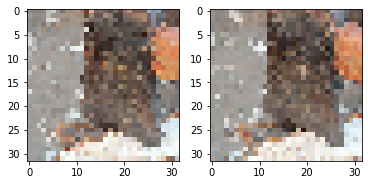

In [3]:
i=50
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(noisy_imgs1[i].permute(1,2,0))
axarr[1].imshow(noisy_imgs2[i].permute(1,2,0))

In [43]:
def compute_psnr(x, y, max_range=1.0):
        assert x.shape == y.shape and x.ndim == 4
        return 20 * torch.log10(torch.tensor(max_range)) - 10 * torch.log10(((x-y) ** 2).mean((1,2,3))).mean()

In [5]:
from torch.nn.modules import padding
class mod(nn.Module):
    def __init__(self, 
                 skip_connections = True, batch_normalization = True):
        super().__init__()
        self.rel=m = nn.RReLU(0.1, 0.3)
        
        self.conv1 = nn.Conv2d(3, 3*4,
                               kernel_size = 8,
                               stride=2,
                               padding = 3)
        
        self.conv21 = nn.Conv2d(3*4, 3*6,
                               kernel_size = 6,
                               padding = 2)
        self.conv22 = nn.Conv2d(3*6, 3*12,
                               kernel_size = 6,
                               padding = 2)
        self.conv23 = nn.Conv2d(3*12, 3*12,
                               kernel_size = 4,
                               padding = 2)

        self.maxlong = nn.MaxPool2d(kernel_size=(3,1),padding=0)
        self.maxwide = nn.MaxPool2d(kernel_size=(1,3),padding=0)
        self.upwide = nn.Upsample(scale_factor=(1,3), mode='nearest')
        self.uplong = nn.Upsample(scale_factor=(3,1), mode='nearest')

        self.conv24 = nn.Conv2d(3*12, 3*4,
                               kernel_size = 2,
                               padding = 1)
        self.conv25 = nn.Conv2d(3*4, 3*4,
                               kernel_size = 5,
                               padding = 2)
        self.conv3 = nn.ConvTranspose2d(3*4, 3,
                                        kernel_size = 8,
                                        stride=2,
                                        padding = 3)
        self.m2=nn.Dropout(p=0.4)
        
    
    def load_pretrained_model(self) -> None:
        #if self.use_cuda:
        self.load_state_dict(torch.load('model.pt'))
        #else:
         #   self.model.load_state_dict(torch.load('model.pt', map_location='cpu'))
    
    
    def forward(self, x):
        y1 = self.conv1(x)
        y = self.m2(y1)
        y = self.conv21(y)
        y = self.rel(y)
        y = self.conv22(y)
        y = self.rel(y)
        y = self.conv23(y)
        ylong=self.maxlong(y)
        ywide=self.maxwide(y)
        y= self.upwide(ywide)+self.uplong(ylong)
        y= self.conv24(y)
        y=self.conv25(y)
        y=y+y1
        y=self.conv3(y)
        #y= 255-self.rel(-(y-255))
        y = F.relu(y)
        
        return y

In [51]:
from piqa import SSIM

class SSIMLoss(SSIM):
    def forward(self, x, y):
        return  super().forward(x, y)

def train_model( train_input, train_target, mini_batch_size, nb_epochs = 100):
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    criterion = psnr
    model=mod()
    model=model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr = 0.001)
    train_input, train_target = train_input.to(device).type(torch.float), train_target.to(device).type(torch.float)

    for e in range(nb_epochs):
        acc_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            optim.zero_grad()
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = -criterion(output/255, train_target.narrow(0, b, mini_batch_size)/255)
            acc_loss = acc_loss + loss.item()
            #print(output)
            loss.backward()
            torch.no_grad()
            optim.step()
        print(e, acc_loss,loss)
    return model

In [54]:
mini_batch_size=100
model=train_model(noisy_imgs2,noisy_imgs1,mini_batch_size,50)

0 -8579.207472801208 tensor(-18.0400, grad_fn=<NegBackward0>)
1 -9046.512201309204 tensor(-18.1580, grad_fn=<NegBackward0>)
2 -9080.620847702026 tensor(-18.1915, grad_fn=<NegBackward0>)
3 -9095.340646743774 tensor(-18.2103, grad_fn=<NegBackward0>)
4 -9103.787508010864 tensor(-18.2306, grad_fn=<NegBackward0>)
5 -9110.273462295532 tensor(-18.2482, grad_fn=<NegBackward0>)
6 -9115.330156326294 tensor(-18.2561, grad_fn=<NegBackward0>)
7 -9120.244709014893 tensor(-18.2551, grad_fn=<NegBackward0>)
8 -9122.937505722046 tensor(-18.2817, grad_fn=<NegBackward0>)
9 -9128.313674926758 tensor(-18.2683, grad_fn=<NegBackward0>)
10 -9130.685182571411 tensor(-18.2901, grad_fn=<NegBackward0>)
11 -9134.415842056274 tensor(-18.2937, grad_fn=<NegBackward0>)
12 -9138.116226196289 tensor(-18.2982, grad_fn=<NegBackward0>)
13 -9141.041368484497 tensor(-18.3021, grad_fn=<NegBackward0>)
14 -9143.33456993103 tensor(-18.3030, grad_fn=<NegBackward0>)
15 -9145.48941040039 tensor(-18.3078, grad_fn=<NegBackward0>)
16 -

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.eval()
score=[]
i=0
clear_imgs=clear_imgs.to(device)
pred=model(noisy_imgs_val.to(device).type(torch.float))
for l in range (noisy_imgs_val.size()[0]):
    score.append(psnr(pred[l]/255,clear_imgs[l]/255).tolist())
import statistics
statistics.mean(score)

25.145756834030152

In [56]:
pred=pred.type(torch.int)

<Figure size 432x288 with 0 Axes>

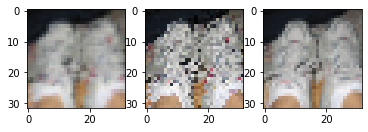

In [57]:
i=560

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(pred[i].permute(1,2,0))
axarr[1].imshow(noisy_imgs_val[i].permute(1,2,0))
axarr[2].imshow(clear_imgs[i].permute(1,2,0))

In [12]:
torch.save(model.state_dict(), 'model.pt')

In [141]:
model=mod()
model.load_pretrained_model()

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# loss

'MSEloss as 0 and psnr loss as 1'

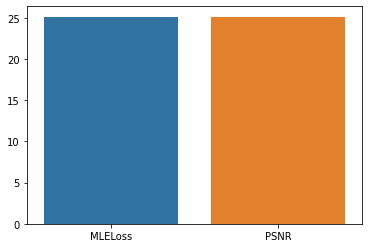

In [28]:
#loss
psnr=[25.088309833526612, 25.115115955352785]
ax = sns.barplot(x=['MLELoss','PSNR'], y=psnr)
'MSEloss as 0 and psnr loss as 1'

# learning rate

In [31]:
#lr using range 0.0001,0.0005,0.001,0.005,0.01,0.05,0.1
x_lr=[24.93562328720093, 25.105369365692138, 25.130658744812013, 6.421886176168918, 6.421886176168918, 6.421886176168918, 6.421886176168918] 
ylr=[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
y_lr_ep=[[26.759811570867896, 13.424492673948407, 11.59158259537071, 10.855461195111275, 10.429260555654764, 10.156562553718686, 9.974806223064661, 9.847321243025362, 9.753817873075604, 9.682791912928224, 9.627622202970088, 9.584555445238948, 9.550466342829168, 9.522616864182055, 9.499920607544482, 9.480677581392229, 9.464794736355543, 9.45073532871902, 9.438315651379526, 9.427343556657434, 9.417264323681593, 9.407044903375208, 9.397283672355115, 9.388275819830596, 9.380765587091446, 9.373637131415308, 9.367186944000423, 9.361204794608057, 9.355459029786289, 9.349993104115129, 9.344494150951505, 9.339096419513226, 9.334041495807469, 9.329406420700252, 9.324315335601568, 9.319568894803524, 9.31486155372113, 9.309981983155012, 9.305829372256994, 9.30176442116499], [15.398852528072894, 10.272110923193395, 9.847485865466297, 9.682178616523743, 9.590755499899387, 9.5324532315135, 9.491888066753745, 9.462715239264071, 9.440229371190071, 9.421788963489234, 9.405624884180725, 9.389191227033734, 9.374223958700895, 9.358547374606133, 9.342548049986362, 9.327151077799499, 9.31370132882148, 9.301929739303887, 9.291363057680428, 9.2821687143296, 9.274294910021126, 9.268019495531917, 9.260517514310777, 9.254423514008522, 9.249612973071635, 9.245046730153263, 9.241088672541082, 9.237370046786964, 9.234272952191532, 9.23147751018405, 9.228431805968285, 9.225715413689613, 9.223359619267285, 9.221185554750264, 9.219538399018347, 9.217600641772151, 9.215635968372226, 9.214186658151448, 9.212420321069658, 9.211150532588363], [14.954648807644844, 10.146649470552802, 9.781507235020399, 9.634460112079978, 9.554469835013151, 9.503766221925616, 9.468114501796663, 9.440924803726375, 9.418563259765506, 9.400526654906571, 9.385937882587314, 9.371845927089453, 9.357558158226311, 9.340917599387467, 9.321132241748273, 9.302715347148478, 9.287090026773512, 9.275721339508891, 9.264760271646082, 9.258713375777006, 9.250418244861066, 9.244557966478169, 9.239745426923037, 9.236173814162612, 9.231452866457403, 9.228317929431796, 9.225669210776687, 9.22419270966202, 9.2214279724285, 9.218744238838553, 9.217217174358666, 9.214956417679787, 9.214183961972594, 9.213229215703905, 9.211189350113273, 9.210626610554755, 9.20987620856613, 9.207991073839366, 9.208096518181264, 9.206659389659762], [74.03523742221296, 13.534633576869965, 11.731729592196643, 10.925205536186695, 10.448426080867648, 10.155652509070933, 9.96305680833757, 9.835591196082532, 9.744201409630477, 9.679182446561754, 9.625001249834895, 9.583642924204469, 9.558394032530487, 9.535489440895617, 1885186592.7836215, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313], [19097.773392915726, 167.81517177820206, 167.81467619538307, 167.8142775297165, 167.81414771080017, 167.8140758574009, 167.81401479244232, 167.8139310479164, 167.8140535056591, 167.81368559598923, 167.81369933485985, 167.8136374950409, 167.81361612677574, 167.8136144578457, 167.81363227963448, 167.81360363960266, 167.8136047422886, 167.81360587477684, 167.81360429525375, 167.81360566616058, 167.81360176205635, 167.8136031627655, 167.81360313296318, 167.81360164284706, 167.81360146403313, 167.8136034309864, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313], [1.922405229966936e+18, 167.81360146403313, 167.81360146403313,
167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313], [5.163736947318712e+17, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313, 167.81360146403313]]

Text(0, 0.5, 'PSNR')

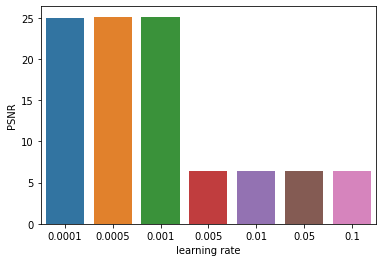

In [37]:
ax = sns.barplot(x=ylr, y=x_lr)
#plt.plot(ylr,x_lr)
#plt.yscale('log')
plt.xlabel('learning rate')
plt.ylabel('PSNR')

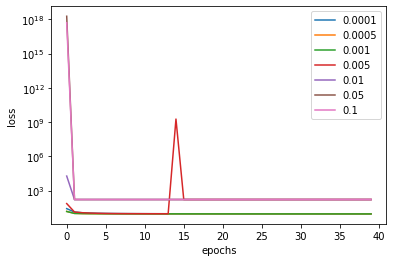

In [8]:
for i in y_lr_ep:
    plt.plot(i)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.yscale('log')
plt.legend(ylr)

In [9]:
#lr on a narroyer band
x_lr1=[24.93562328720093,25.12411684036255, 25.113871849060057, 25.11350291633606, 25.093932933807373, 25.029800559997557]
y_lr_ep1=[[26.759811570867896, 13.424492673948407, 11.59158259537071, 10.855461195111275, 10.429260555654764, 10.156562553718686, 9.974806223064661, 9.847321243025362, 9.753817873075604, 9.682791912928224, 9.627622202970088, 9.584555445238948, 9.550466342829168, 9.522616864182055, 9.499920607544482, 9.480677581392229, 9.464794736355543, 9.45073532871902, 9.438315651379526, 9.427343556657434, 9.417264323681593, 9.407044903375208, 9.397283672355115, 9.388275819830596, 9.380765587091446, 9.373637131415308, 9.367186944000423, 9.361204794608057, 9.355459029786289, 9.349993104115129, 9.344494150951505, 9.339096419513226, 9.334041495807469, 9.329406420700252, 9.324315335601568, 9.319568894803524, 9.31486155372113, 9.309981983155012, 9.305829372256994, 9.30176442116499],[17.024839509278536, 10.83762871939689, 10.163270396180451, 9.877946755848825, 9.725271890871227, 9.630541406571865, 9.56573905237019, 9.51857862342149, 9.482833835296333, 9.454377700574696, 9.430726004764438, 9.412272300571203, 9.396470011211932, 9.38233650289476, 9.367778848856688, 9.353870183229446, 9.33907463401556, 9.325959180481732, 9.313832498155534, 9.30221812799573, 9.29153117351234, 9.282973111607134, 9.274429588578641, 9.267898353748024, 9.261660040356219, 9.25557728111744, 9.250442952848971, 9.24578913114965, 9.241558877751231, 9.237894348800182, 9.234055592678487, 9.230613007210195, 9.226987128145993, 9.223724000155926, 9.221644235774875, 9.218478567898273, 9.216310437768698, 9.21388646401465, 9.211708812974393, 9.209493671543896], [15.502903777174652, 10.437544493936002, 9.939685782417655, 9.736069055274129, 9.624898429960012, 9.555874085053802, 9.510145174339414, 9.47777206171304, 9.45417741779238, 9.436015694402158, 9.419728453271091, 9.404221684671938, 9.39046964328736, 9.375950664281845, 9.35861440654844, 9.342271686531603, 9.326813635416329, 9.312979588285089, 9.300054589286447, 9.290505611337721, 9.281260862015188, 9.273556703701615, 9.266973124817014, 9.261620028875768, 9.25583894457668, 9.251715849153697, 9.246874121017754, 9.243093261495233, 9.238859099335968, 9.2355479542166, 9.232145502232015, 9.229359457269311, 9.22648612037301, 9.224480168893933, 9.221413319930434, 9.219419727101922, 9.216710754670203, 9.215049806982279, 9.213286686688662, 9.211586024612188], [14.969436721876264, 10.147623714059591, 9.797145443968475, 9.654147072695196, 9.573680818080902, 9.520925818942487, 9.483079659752548, 9.455027541145682, 9.431753083132207, 9.412791351787746, 9.396682612597942, 9.38105002604425, 9.365388207137585, 9.349494418129325, 9.333876193501055, 9.319133976474404, 9.3051942801103, 9.293614026159048, 9.283742284402251, 9.274773430079222, 9.267388818785548, 9.260582515969872, 9.25506607349962, 9.248287504538894, 9.24456946644932, 9.239511402323842, 9.236602018587291, 9.232813403941691, 9.229804953560233, 9.227319862693548, 9.224625405855477, 9.222947667352855, 9.22062161564827, 9.218076073564589, 9.216664342209697, 9.214873041026294, 9.213441441766918, 9.21149024926126, 9.210963848978281, 9.208640255965292], [14.267714272253215, 9.995358451269567, 9.700282071717083, 9.583675025962293, 9.521743540652096, 9.481238914653659, 9.452325482852757, 9.43122490029782, 9.41138428915292, 9.39521234575659, 9.380222680978477, 9.362026498652995, 9.34426167421043, 9.323564175516367, 9.308309186249971, 9.290744645521045, 9.28008892852813, 9.270120800472796, 9.262570665217936, 9.256060656160116, 9.248279738239944, 9.245392075739801, 9.24060120433569, 9.236935527995229, 9.233235233463347, 9.230336238630116, 9.226952848955989, 9.22571689169854, 9.223257794976234, 9.221187317743897, 9.218929378315806, 9.217696730978787, 9.21649553347379, 9.215195391327143, 9.213905585929751, 9.21253717597574, 9.211855909787118, 9.210587028414011, 9.209451654925942, 9.209523843601346], [12.34842926170677, 9.75648383051157, 9.564817209728062, 9.496813748963177, 9.45720397029072, 9.430472017265856, 9.414959500543773, 9.399359874427319, 9.380747014656663, 9.368869541212916, 9.352573366835713, 9.331336254253983, 9.316022625193, 9.301528853364289, 9.296043221838772, 9.287395018152893, 9.28381980303675, 9.277522805146873, 9.276040805503726, 9.273247042670846, 9.268879778683186, 9.267267426475883, 9.261824962683022, 9.262838996946812, 9.258878805674613, 9.256689664907753, 9.255414668470621, 9.253611641004682, 9.2522606626153, 9.25132020469755, 9.248519357293844, 9.249645640142262, 9.247970785945654, 9.24685382656753, 9.244116118177772, 9.245820336975157, 9.24366101808846, 9.24206552747637, 9.243850321508944, 9.24187427200377]]
ylr1=[0.0001,0.0003,0.0005,0.0008,0.001,0.002]

Text(0, 0.5, 'PSNR')

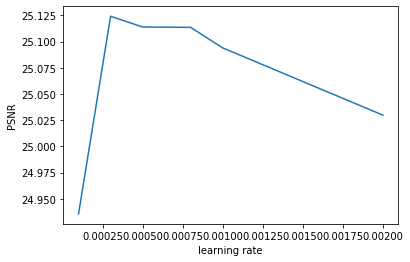

In [10]:
plt.plot(ylr,x_lr)
#plt.xscale('log')
plt.xlabel('learning rate')
plt.ylabel('PSNR')

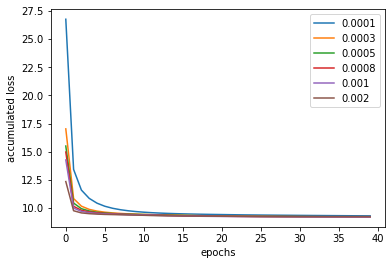

In [11]:
for i in y_lr_ep:
    plt.plot(i)
plt.ylabel('accumulated loss')
plt.xlabel('epochs')
#plt.yscale('log')
plt.legend(ylr)

# weight initialisation

In [12]:
#weight initialisation using [none, bias uniform, xavier_normal for weights and bias uniform,normal for weights and bias uniform]
w=['none',' bias uniform', 'xavier_normal for weights and bias uniform','normal for weights and bias uniform']
y_weight_innit=[[15.653672930784523,
 10.261530286632478,
 9.827201187610626,
 9.65846397075802,
 9.569879034534097,
 9.515689096413553,
 9.479809526354074,
 9.454356920905411,
 9.43488191254437,
 9.418296343646944,
 9.403743048198521,
 9.389926813542843,
 9.375427127815783,
 9.358795345760882,
 9.342283582314849,
 9.324486432597041,
 9.308448969386518,
 9.294423730112612,
 9.283228991553187,
 9.27298881392926,
 9.264691784977913,
 9.257099227048457,
 9.251083292998374,
 9.245673725381494,
 9.240919513627887,
 9.23587697930634,
 9.231351693160832,
 9.228078573010862,
 9.224252671003342,
 9.22120660636574],[16.0577066289261,
 10.228829662315547,
 9.811390454880893,
 9.654152539558709,
 9.570101954042912,
 9.517494092695415,
 9.482346536591649,
 9.456814013421535,
 9.43589355610311,
 9.415330903604627,
 9.39766288176179,
 9.381635091267526,
 9.36622931715101,
 9.350671241991222,
 9.334587869234383,
 9.318865739740431,
 9.304617423564196,
 9.292382312007248,
 9.282568795606494,
 9.274342246353626,
 9.267294133082032,
 9.261049144901335,
 9.254517065361142,
 9.249563339166343,
 9.245749562978745,
 9.241410386748612,
 9.238327356055379,
 9.234598338603973,
 9.231243649497628,
 9.227932944893837],[15.349052915349603,
 10.330601325258613,
 9.88984115421772,
 9.710808209143579,
 9.612591609358788,
 9.549732718616724,
 9.506507342681289,
 9.475275445729494,
 9.45163987763226,
 9.433488455601037,
 9.419003325514495,
 9.40673164371401,
 9.395417077466846,
 9.385080725885928,
 9.374672432430089,
 9.363888912834227,
 9.351828743703663,
 9.34138048067689,
 9.330728593282402,
 9.321851825341582,
 9.311968023888767,
 9.302518642507493,
 9.293471982702613,
 9.285323060117662,
 9.276970107108355,
 9.270498687401414,
 9.264071321114898,
 9.258653290569782,
 9.253532122820616,
 9.247904175892472],[5.037862088354038e+17,
 6119633365499904.0,
 1681864576860160.0,
 695160858345472.0,
 334872953094144.0,
 179059379232768.0,
 99737393385472.0,
 59102947059712.0,
 36552820027392.0,
 22481956136448.0,
 14851240848128.0,
 9129263146240.0,
 6026553389088.0,
 4197318964728.0,
 2852844421119.781,
 1823847986698.5425,
 1326721629609.3196,
 912053952737.4528,
 612060325728.5956,
 477646894412.9617,
 347718428412.8105,
 268145260752.5857,
 203413848143.72086,
 118127194828.5035,
 104942149363.31523,
 68527424096.09,
 71135830535.00311,
 52695662033.69408,
 35424631673.90816,
 28926683969.462486]]

In [13]:
psnr_weight_innit=[25.08732513809204,25.087283992767333,25.048596147537232,6.208961403906345]

Text(0, 0.5, 'PSNR')

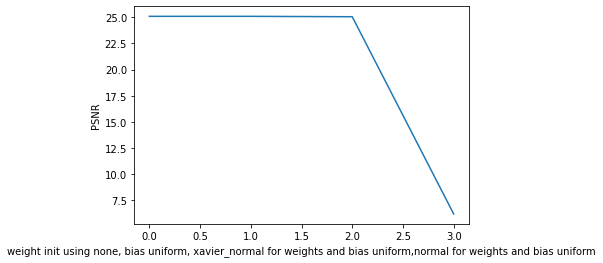

In [14]:
plt.plot(psnr_weight_innit)

plt.xlabel('weight init using none, bias uniform, xavier_normal for weights and bias uniform,normal for weights and bias uniform')
plt.ylabel('PSNR')

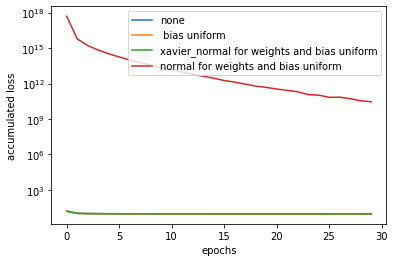

In [15]:
for i in y_weight_innit:
    plt.plot(i)
plt.ylabel('accumulated loss')
plt.xlabel('epochs')
plt.yscale('log')
plt.legend(w)

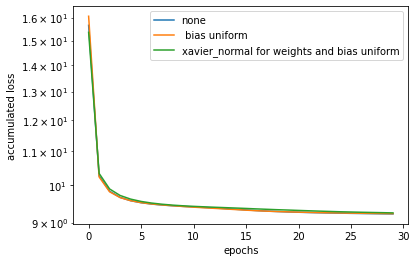

In [16]:
for i in y_weight_innit[:-1]:
    plt.plot(i)
plt.ylabel('accumulated loss')
plt.xlabel('epochs')
plt.yscale('log')
plt.legend(w)

# batch size

In [17]:
#batch size
PSNR_batch=[24.91178806114197, 25.071928440093995, 25.082313165664672, 25.112721733093263, 24.6817236995697]
acc_loss_batch=[[82.34636234957725, 75.43384807556868, 75.09112225472927, 74.87082150066271, 74.73788656992838, 74.64674496138468, 74.568973693531, 74.51344376197085, 74.4701910787262, 74.44672773731872, 74.41747342608869, 74.3901990884915, 74.3752281581983, 74.35787057504058, 74.34593326831236, 74.3343438655138, 74.31475934805349, 74.31412166776136, 74.30331607768312, 74.28726272843778, 74.28962581790984, 74.28016485646367, 74.27384051028639, 74.27504611434415, 74.26728949183598, 74.2592592863366, 74.2639433182776, 74.25396228861064, 74.24565529357642, 74.24840492103249, 74.24385471595451, 74.23984409542754, 74.24584803450853, 74.24029137426987, 74.24119305843487, 74.23224233044311, 74.23106133705005, 74.22593865916133, 74.22992004733533, 74.2311321250163], [19.984161073341966, 15.477494868449867, 15.231142689473927, 15.126081426627934, 15.065820158459246, 15.019249802455306, 14.973133908584714, 14.937344145961106, 14.908498297445476, 14.882922594435513, 14.865263509564102, 14.851146102882922, 14.838049255311489, 14.829421716742218, 14.819676605984569, 14.81218601576984, 14.805516498163342, 14.799864233471453, 14.794811501167715, 14.789937973953784, 14.786413088440895, 14.783869278617203, 14.779415514320135, 14.776599168777466, 14.774003179743886, 14.771663022227585, 14.77029244415462, 14.768954516388476, 14.766319510526955, 14.765827256254852, 14.761798623017967, 14.760740744881332, 14.759915093891323, 14.755944140255451, 14.755905134603381, 14.75490059517324, 14.753962634131312, 14.751788472756743, 14.750371490605175, 14.74989394750446], [13.56409043353051, 9.954846125096083, 9.678038854151964, 9.565326751209795, 9.502302024513483, 9.461933696642518, 9.432242058217525, 9.410018215887249, 9.391683439724147, 9.374748224392533, 9.356646780855954, 9.33432247210294, 9.312703981995583, 9.299270931631327, 9.28577278740704, 9.274812795221806, 9.266771732829511, 9.261758766137064, 9.253907915204763, 9.249315195716918, 9.244790500029922, 9.240642569027841, 9.237966733053327, 9.235190863721073, 9.231366142630577, 9.228776818141341, 9.227275026962161, 9.224969075992703, 9.22332686651498, 9.221108853816986, 9.219197371043265, 9.218177821487188, 9.21730697248131, 9.215183640830219, 9.214139972813427, 9.212929390370846, 9.212676647119224, 9.211216549389064, 9.210882707498968, 9.209859896451235], [12.129053727723658, 8.12448906712234, 7.838240162469447, 7.720712010748684, 7.656549428589642, 7.614954045042396, 7.585103486664593, 7.562066903337836, 7.543592258356512, 7.52785515692085, 7.513259571045637, 7.49852052051574, 7.4836073108017445, 7.468724909238517, 7.456359952688217, 7.445313877426088, 7.43498953897506, 7.426484207622707, 7.419794773682952, 7.413430362008512, 7.4085285337641835, 7.403141954913735, 7.399379789829254, 7.395658351480961, 7.392099711112678, 7.389021304436028, 7.387656697072089, 7.38443757686764, 7.382446201518178, 7.380780316889286, 7.3786466885358095, 7.377518855035305, 7.375417207367718, 7.374161473475397, 7.373374968767166, 7.372123905457556, 7.370849361643195, 7.369813350960612, 7.368516882881522, 7.367819745093584], [4.626476272940636, 2.0866186004132032, 1.8535916078835726, 1.7553519941866398, 1.698988737538457, 1.6623628437519073, 1.6356170577928424, 1.6160979941487312, 1.601160411722958, 1.5885761585086584, 1.578764969483018, 1.5705245705321431, 1.5634397994726896, 1.5576751036569476, 1.5523508675396442, 1.548280905932188, 1.5440406473353505, 1.5412626983597875, 1.5374975679442286, 1.5351071627810597, 1.5324578052386642, 1.5298674535006285, 1.5286976108327508, 1.5255061080679297, 1.5243256036192179, 1.5227304454892874, 1.5208636550232768, 1.5198890287429094, 1.5178778944537044, 1.5173500338569283, 1.515577245503664, 1.5151570457965136, 1.5135126020759344, 1.5132252303883433, 1.5118597466498613, 1.5113938180729747, 1.5104999477043748, 1.5095367496833205, 1.5093935364857316, 1.5080381352454424]]
batch=[10,50,80,100,500]

Text(0, 0.5, 'PSNR')

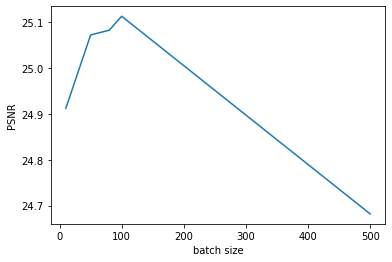

In [18]:
plt.plot(batch,PSNR_batch)
#plt.xscale('log')
plt.xlabel('batch size')
plt.ylabel('PSNR')

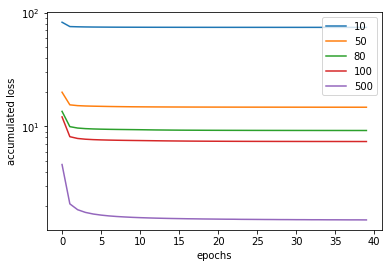

In [19]:
for i in acc_loss_batch:
    plt.plot(i)
plt.ylabel('accumulated loss')
plt.xlabel('epochs')
plt.yscale('log')
plt.legend(batch)

# epoch number

In [20]:
PSNR_epoch=[23.38160761833191, 24.5647689037323, 24.782274150848387, 25.039688249588014, 25.134096370697023, 25.11549464416504, 25.131743423461913]
epoch_acc_loss=[[13.641932055354118], [13.766663045622408, 9.900498176924884, 9.653558764606714, 9.556046781130135, 9.499447331763804], [13.527166144922376, 9.872005062177777, 9.631461016833782, 9.536273064091802, 9.48439444322139, 9.452112355269492, 9.428778418339789, 9.410136813297868, 9.392325136810541, 9.373810578137636], [13.897440670989454, 9.927633816376328, 9.664766068570316, 9.562553792260587, 9.504766946658492, 9.466767181642354, 9.44102705270052, 9.42029124405235, 9.399765672162175, 9.380946507677436, 9.364796161651611, 9.34793929103762, 9.333078919909894, 9.314535981975496, 9.301423646509647, 9.290862400084734, 9.280148933641613, 9.275663604028523, 9.267956578172743, 9.261567950248718, 9.256185919977725, 9.252065939828753, 9.245616056025028, 9.242947795428336, 9.241284561343491], [13.712259666062891, 9.939346733503044, 9.672949959523976, 9.572576456703246, 9.511544644832611, 9.473418341949582, 9.444404445588589, 9.419448311440647, 9.398513544350863, 9.38096812646836, 9.363106904551387, 9.344118027947843, 9.325212202966213, 9.306067660450935, 9.291821332648396, 9.282500778324902, 9.272922677919269, 9.265493246726692, 9.258564768359065, 9.252492011524737, 9.247659105807543, 9.243192907422781, 9.239166245795786, 9.23546461481601, 9.232079176232219, 9.229884203523397, 9.226260293275118, 9.224111837334931, 9.222290082834661, 9.219644765369594, 9.217931750230491, 9.216670397669077, 9.214612217620015, 9.213769543915987, 9.212676874361932, 9.21148863621056, 9.209756811149418, 9.210019531659782, 9.208606668747962, 9.207264643162489, 9.206194631755352, 9.20560740493238, 9.205059068277478, 9.204549791291356, 9.203882404603064, 9.203167237341404, 9.202077257446945, 9.20231903437525, 9.200616280548275, 9.200957985594869], [13.419992564246058, 9.929353611543775, 9.675896651111543, 9.567849716171622, 9.509437777101994, 9.471328395418823, 9.442832893691957, 9.4205926284194, 9.402393443509936, 9.388399379327893, 9.374552725814283, 9.360110463574529, 9.342131051234901, 9.32727421168238, 9.31151040457189, 9.298973063006997, 9.287878021597862, 9.278020650148392, 9.270511391572654, 9.263841407373548, 9.257470324635506, 9.252265518531203, 9.247582625597715, 9.243584383279085, 9.239408339373767, 9.23594550229609, 9.233773803338408, 9.229130732826889, 9.227646444924176, 9.22525521647185, 9.223313329741359, 9.221079526469111, 9.220701158978045, 9.21677655633539, 9.216188141144812, 9.215171528048813, 9.213729597628117, 9.211833328008652, 9.212348701432347, 9.209921771660447, 9.209750370122492, 9.206881016492844, 9.207909549586475, 9.207858518697321, 9.206066656857729, 9.205107195302844, 9.20486112125218, 9.203943479806185, 9.20289702154696, 9.20293480437249, 9.201715525239706, 9.20058976020664, 9.200443307869136, 9.199768257327378, 9.19969370868057, 9.19918408896774, 9.198195361532271, 9.198226681910455, 9.198754215613008, 9.19741611275822, 9.19730216357857, 9.195852124132216, 9.196128878742456, 9.195974639616907, 9.195728345774114, 9.194857840426266, 9.19503331091255, 9.194487299770117, 9.19462893344462, 9.193922596983612], [12.901969294063747, 9.885893900878727, 9.649993828497827, 9.551276290789247, 9.499246202409267, 9.464963574893773, 9.438120349310338, 9.415664582513273, 9.396951558068395, 9.376001757569611, 9.35745597165078, 9.336753486655653, 9.319902637973428, 9.304221742786467, 9.291703685186803, 9.282469231635332, 9.271942854858935, 9.266025537624955, 9.260387048125267, 9.254633910022676, 9.249336892738938, 9.246170842088759, 9.240708651952446, 9.237880514003336, 9.23522098455578, 9.231722460128367, 9.230364830233157, 9.227804586291313, 9.226610934361815, 9.223158887587488, 9.22221824619919, 9.220250601880252, 9.21800128556788, 9.216700851917267, 9.216204311698675, 9.214806225150824, 9.21343164332211, 9.21244026068598, 9.211674035526812, 9.20978828612715, 9.21004848740995, 9.20857128687203, 9.207385098561645, 9.207806554622948, 9.20666216313839, 9.205602705478668, 9.20636425446719, 9.20406382996589,9.20443119853735, 9.203204148449004, 9.203479084186256, 9.202572220005095, 9.201439949683845, 9.203074977733195, 9.200668009929359, 9.201184088364244, 9.200552139431238, 9.200142172165215, 9.198922090232372, 9.199243297800422, 9.197811014950275, 9.199572943150997, 9.198363074101508, 9.197374077513814, 9.196908300742507, 9.197680987417698, 9.197043127380311, 9.195429879240692, 9.195790970697999, 9.1967450696975, 9.19500510301441, 9.195231669582427, 9.19386668689549, 9.193810632452369, 9.194871961139143, 9.194410063326359, 9.193852580152452, 9.19368592929095, 9.192561813630164, 9.193317658267915, 9.193555464036763, 9.19204336963594, 9.192272372543812, 9.192085249349475, 9.192016085609794, 9.191805044189095, 9.191706836223602, 9.192605816759169, 9.190926222130656, 9.190744018182158, 9.190386953763664, 9.190917037427425, 9.191581505350769, 9.190322890877724, 9.189943564124405, 9.190266072750092, 9.18877701740712, 9.189906859770417, 9.189508457668126, 9.189594109542668]]
epochs=[1,5,10,25,50,70,100]

Text(0, 0.5, 'PSNR')

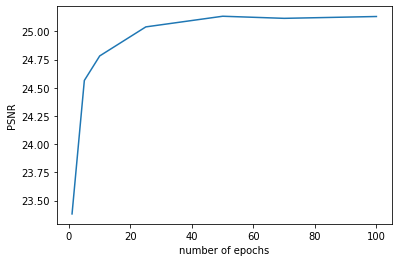

In [21]:
plt.plot(epochs,PSNR_epoch)
#plt.xscale('log')
plt.xlabel('number of epochs')
plt.ylabel('PSNR')

# optimizer

In [22]:
optim=['Adam', 'Nadam', 'SGD','Adadelta']
PSNR_opti=[25.10144614982605,24.981842752456664,12.85005370759964,16.75372280025482]

In [23]:
acc_loss=[[15.30684282630682,
 10.223689901642501,
 9.811335360631347,
 9.653440204448998,
 9.570798352360725,
 9.518541743047535,
 9.481751221232116,
 9.453740386292338,
 9.431208848021924,
 9.411619453690946,
 9.394962581805885,
 9.37978248950094,
 9.365708000026643,
 9.35195641219616,
 9.335776980035007,
 9.319726110436022,
 9.304554617963731,
 9.293147871270776,
 9.283614568412304,
 9.273916189558804,
 9.266666098497808,
 9.26032949052751,
 9.254676387645304,
 9.248289027251303,
 9.243479002267122,
 9.239278063178062,
 9.2354737194255,
 9.231621206738055,
 9.228592610917985,
 9.225192678160965],[17.111144514754415,
 10.959632875397801,
 10.352391852997243,
 10.077021824195981,
 9.916017797775567,
 9.803879496641457,
 9.727221458218992,
 9.661838378757238,
 9.613125146366656,
 9.572129876352847,
 9.536680842749774,
 9.505609220825136,
 9.478469255380332,
 9.4537880923599,
 9.431026850827038,
 9.411393590271473,
 9.392174035310745,
 9.374793441966176,
 9.357034374959767,
 9.340876182541251,
 9.326076356694102,
 9.31340358313173,
 9.302384432405233,
 9.292447318322957,
 9.284484181553125,
 9.277624047361314,
 9.270934987813234,
 9.264509912580252,
 9.259713712148368,
 9.254636357538402],[125.46385437250137,
 84.5772819891572,
 75.0811438113451,
 66.40793228149414,
 64.89424479752779,
 63.98994401842356,
 63.20792296528816,
 62.50815585255623,
 61.87367572635412,
 61.29372754693031,
 60.75616143643856,
 60.24823106080294,
 59.740686401724815,
 59.04201056063175,
 53.55210266262293,
 48.77362561970949,
 47.84164569526911,
 47.23950994759798,
 46.703081496059895,
 46.21474386006594,
 45.76824443787336,
 45.3595450296998,
 44.98759987950325,
 44.64920164644718,
 44.342058427631855,
 44.063288282603025,
 43.80946246534586,
 43.576344192028046,
 43.36153802648187,
 43.16253283247352],[122.22650021314621,
 82.1269743964076,
 62.47234097123146,
 57.49499061703682,
 54.75194043666124,
 45.947456642985344,
 43.5603585653007,
 42.36318386718631,
 38.893488604575396,
 33.30671812593937,
 32.07030561193824,
 31.207022957503796,
 30.411378741264343,
 29.661907006055117,
 28.94222815707326,
 28.241121850907803,
 27.547811090946198,
 26.85811235755682,
 26.17077834904194,
 25.49644836783409,
 24.852805592119694,
 24.258802384138107,
 23.730619724839926,
 23.269593194127083,
 22.869253907352686,
 22.519453041255474,
 22.205140253528953,
 21.91800869256258,
 21.651560040190816,
 21.40005622804165]]

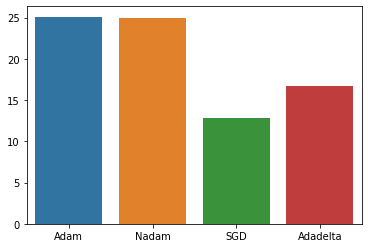

In [25]:

ax = sns.barplot(x=optim, y=PSNR_opti)

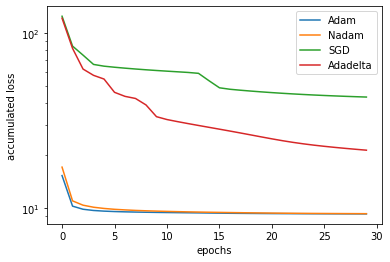

In [38]:
for i in acc_loss:
    plt.plot(i)
plt.ylabel('accumulated loss')
plt.xlabel('epochs')
plt.yscale('log')
plt.legend(optim)